# Training the SPOCK model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with genNewTrainData.ipynb

In [2]:
#load datapath for clean training data
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'cleanTmaxData.csv')
#cleanTmaxData.csv for int to Tmax
#TmaxOr1e4.csv for into to 1e4 or Tmax, whichever is greater
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [3]:
dataset['InitialStable'].value_counts()

InitialStable
1.0    96825
0.0     5672
Name: count, dtype: int64

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [4]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    #test = test.drop(test[test['logTmax']>3.75].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [5]:
dataset['logTmax']=np.log10(dataset['Tmax'])

In [6]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno 
oldFeat = near + far + megno

trainX, trainY, testX, testY = train_test(dataset, features)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We can determine the idea values for the different hyperparameters.

We will start by creating and testing a collection of models that have randomly selected hyperparameters

scale_pos_weight is a hyperparameter used to account for skewed training data, it does this by weighting false positives and negatives differently. A typical value can be obtained by dividing your negative outcomes in your training data by your positive outcomes.

In [7]:
trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]

We can then establish the different parameter space that we will be testing different hyperparameter values within.

In [8]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 150,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,
                            scale_pos_weight = trainingBalance)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can then create and evaluate the different trials

In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.9248221048735765                                     
ERROR                                                  
0.0018617381617800487                                  
SCORE:                                                                            
0.9248115043246452                                                                
ERROR                                                                             
0.001956994805549005                                                              
SCORE:                                                                            
0.9291666174256668                                                                
ERROR                                                                             
0.0022377079874142123                                                             
SCORE:                                                                            
0.922771970365071            

We can not determine what values for hyperparameters will be ideal. We can do this by plotting how AUC changes as we alter each hyperparameter.

Here we will find that an optimal max_depth would be 15, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

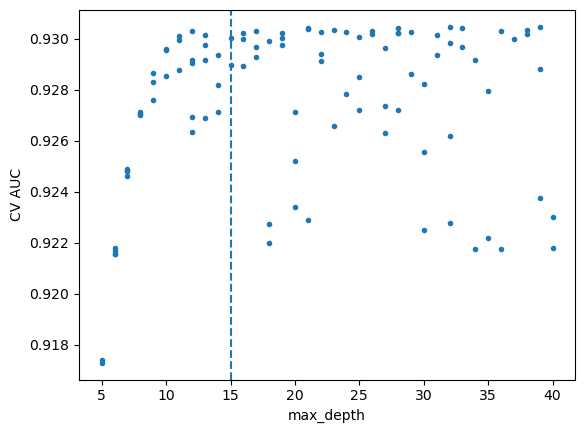

In [10]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
subsample = trials.vals['x_subsample']
aucs = np.array([1-x['loss'] for x in trials.results])
fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.axvline(15, linestyle='--')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

Here we will find that an optimal min_childs would be 10, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

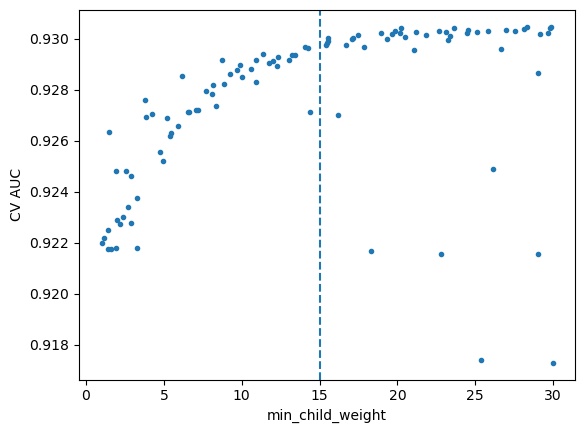

In [11]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.axvline(15, linestyle='--')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Here we will find that an optimal subsample value would be 0.95 due to a malignly higher concentration of high preforming models. Most values seem to give good enough results.

Text(0, 0.5, 'CV AUC')

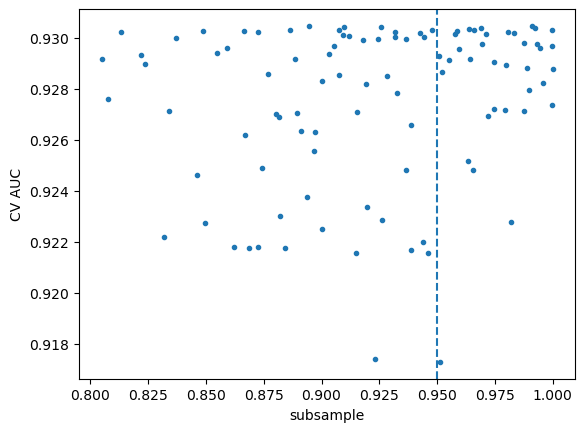

In [12]:
fig, ax = plt.subplots()
ax.plot(subsample, aucs, '.')
ax.axvline(.95, linestyle='--')
ax.set_xlabel('subsample')
ax.set_ylabel('CV AUC')

We can now determine, with these new values, what the optimal number of n_estimators is.

In [13]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         scale_pos_weight = trainingBalance)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.94508+0.00071	test-auc:0.91756+0.00251
[1]	train-auc:0.95261+0.00064	test-auc:0.92452+0.00221
[2]	train-auc:0.95542+0.00044	test-auc:0.92675+0.00250
[3]	train-auc:0.95756+0.00047	test-auc:0.92907+0.00221
[4]	train-auc:0.95890+0.00047	test-auc:0.93030+0.00192
[5]	train-auc:0.96009+0.00046	test-auc:0.93113+0.00177
[6]	train-auc:0.96112+0.00039	test-auc:0.93165+0.00175
[7]	train-auc:0.96190+0.00046	test-auc:0.93217+0.00174
[8]	train-auc:0.96267+0.00046	test-auc:0.93255+0.00183
[9]	train-auc:0.96339+0.00047	test-auc:0.93299+0.00195
[10]	train-auc:0.96406+0.00045	test-auc:0.93340+0.00201
[11]	train-auc:0.96470+0.00051	test-auc:0.93377+0.00201
[12]	train-auc:0.96530+0.00046	test-auc:0.93411+0.00198
[13]	train-auc:0.96595+0.00043	test-auc:0.93440+0.00198
[14]	train-auc:0.96653+0.00034	test-auc:0.93460+0.00196
[15]	train-auc:0.96705+0.00035	test-auc:0.93478+0.00197
[16]	train-auc:0.96764+0.00034	test-auc:0.93508+0.00195
[17]	train-auc:0.96821+0.00034	test-auc:0.93531+0.00199
[1

Here we will find that an optimal number of estimators would be about 125.

Text(0, 0.5, 'CV AUC score')

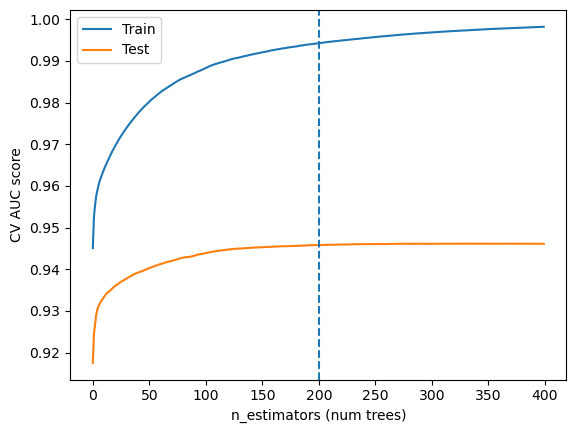

In [14]:
n_estimators = 200
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

# SPOCK

We can now train the final spock model

In [15]:
dataset['logTmax']=np.log10(dataset['Tmax'])

In [16]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [17]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)


In [18]:
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'ROC curve (AUC = 0.944)')

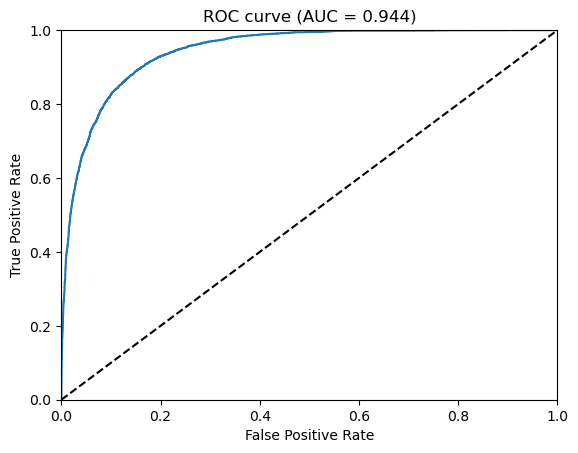

In [19]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [20]:
#check exact number
roc_auc

0.9441924253093325

We can check FPR when we have a TPR of .9

In [21]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
fpr[tprthreshindex]

0.16158432124991434

We can check feature importance

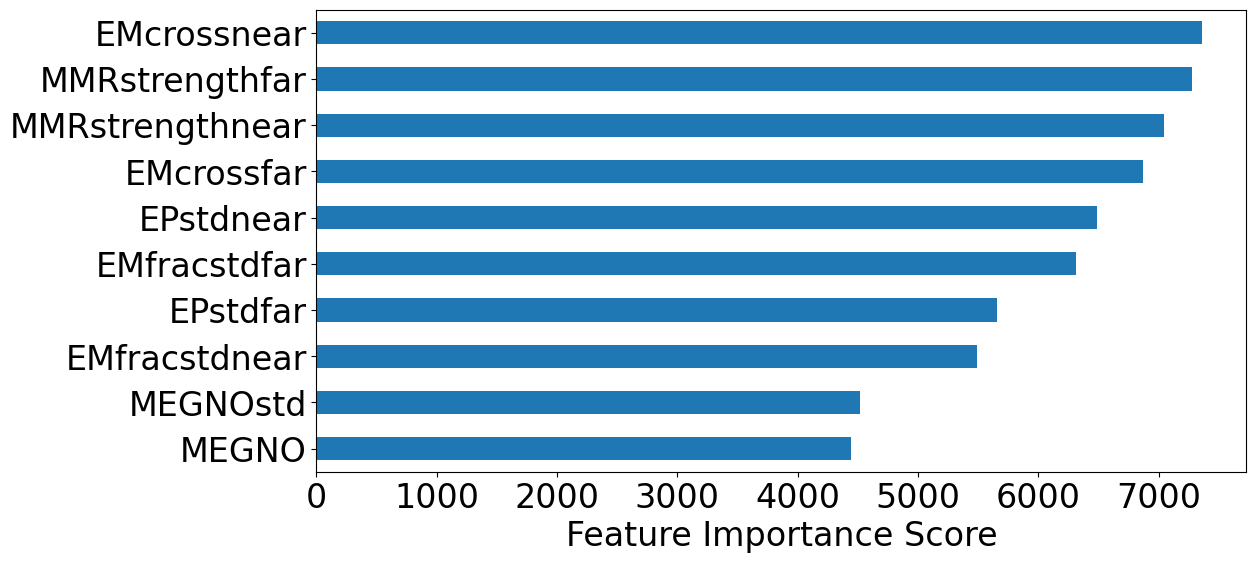

In [22]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

Here we can see that the model trained with features generated by integrating to 5 times the secular time scale preforms only slightly better then if you only integrate to 1e4. Since integrating based on the secular time scale has a large negative impact on the computational power required, we can conclude that the cost is not worth the benifit.

array([[<Axes: title={'center': 'logTmax'}>]], dtype=object)

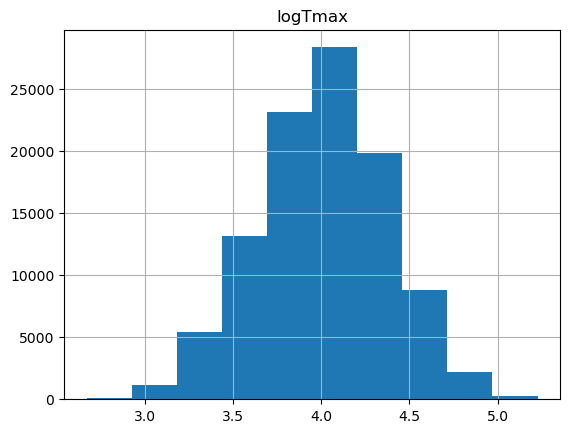

In [23]:
dataset.hist('logTmax')

# testing original spock model

In [24]:
#load datapath for clean training data
datapath = '../../cleanData/csvs/resonant/'

regtime = pd.read_csv(datapath+'CleanResTrainingData.csv')
#remove junk columns
regtime = regtime.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
regtime = regtime[oldFeat+['Stable','InitialStable']]
temp = (dataset ['InitialStable'] ==1)& (regtime['InitialStable']==1)

In [25]:
regtime['InitialStable']= temp
regtime['logTmax']=np.log10(dataset['Tmax'])

In [26]:
Otrainx,Otrainy,Otestx,OtestY =train_test(regtime, oldFeat)

Text(0.5, 1.0, 'ROC curve (AUC = 0.943)')

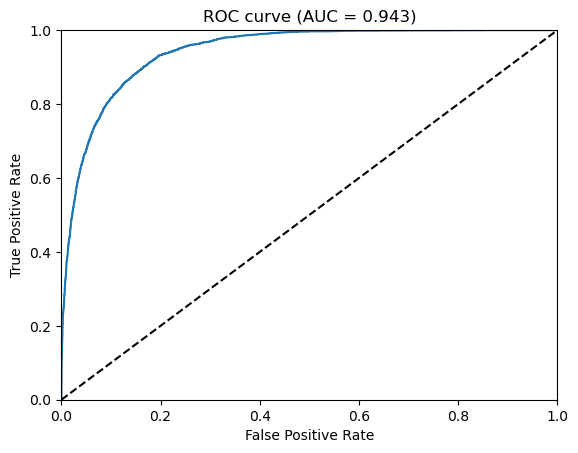

In [27]:
from spock import FeatureClassifier
spock = FeatureClassifier()
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(spock.model, Otestx, OtestY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [28]:
roc_auc

0.9428339796596639

In [29]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
fpr[tprthreshindex]

0.16551379875918135

In [30]:
Otestx

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd
81997,0.024634,0.106314,0.000257,0.036110,0.274613,0.007796,0.000146,0.000490,63.134423,15.691709
81998,0.081286,0.309786,0.009878,0.031652,0.210075,0.050212,0.000145,0.323946,52.107639,13.098047
81999,0.162439,0.146200,0.001691,0.862384,0.789549,0.089403,0.040977,NaN,1.928527,0.033700
82000,0.211804,0.244091,0.017831,0.603572,0.212892,0.021315,0.001332,0.834075,2.673614,0.413931
82001,0.045627,0.013530,0.000117,0.021032,0.090419,0.016862,0.001209,0.005019,1.911721,0.043485
...,...,...,...,...,...,...,...,...,...,...
102491,0.252022,0.048130,0.007128,1.064069,0.560303,0.020432,0.003597,0.166145,1.988414,0.006829
102492,0.089252,0.274872,0.011063,0.050574,0.310694,0.033604,0.000987,1.041204,75.482329,20.204394
102493,0.082222,0.049940,0.016289,0.614960,0.664222,0.031330,0.003745,NaN,1.998822,0.003453
102494,0.131799,0.027696,0.001457,0.660450,0.366664,0.067480,0.020412,0.005440,7.135916,1.918209


dataset.hist()